## Temporal Difference Method

The dynamic programming methods introduced so far require full knowledge of the MDP, which is often not available in practice. Typically, we cannot explicitly write out the transition probability matrices; instead, we can only sample transitions by interacting with the environment. Learning methods that rely on such sampling—rather than assuming access to the full MDP—are known as **Model-Free Reinforcement Learning**. 

Recall the incremental formula for approximating value function in Monte Carlo Method:
\begin{align}
V_n(s) &= \frac{1}{n}\sum_{i=1}^n G_i \notag \\
       &= \frac{n-1}{n} \sum_{i=1}^{n-1} G_i + \frac{1}{n} G_n \notag \\
       &= V_{n-1}(s) - \frac{1}{n} V_{n-1}(s) + \frac{1}{n} G_n \notag \\
       &= V_{n-1}(s) + \frac{1}{n} (G_n - V_{n-1})(s))
\end{align}

We can also replace $\frac{1}{n}$ by any arbitary learning rate $\alpha$

### Sarsa
Instead of using the entire process to approximate value function at time $t$ as in Monte Carlo Mathod, One Temporal difference method called **Sarsa**, use immediate reward plus value function at time $t+1$ to approximate value function at time $t$. In this case:
$$ V(s_t) \leftarrow V(s_t) _ \alpha [r_t + \gamma V(s_{t+1}) - V(s_t)] $$

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [4]:
class CliffWalkingEnv:
    def __init__(self, nrow, ncol):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1

    def step(self, action):
        change = [[0,-1],[0,1],[-1,0],[1,0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward =  -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done 
        
    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x 


In [13]:
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a 
    
    def update(self, s0, a0, r, s1,a1):
        td_error = r + self.gamma * self.Q_table[s1,a1] - self.Q_table[s0,a0]
        self.Q_table[s0, a0 ] += self.alpha * td_error    

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 9967.93it/s, episode=500, return=-18.900000] 


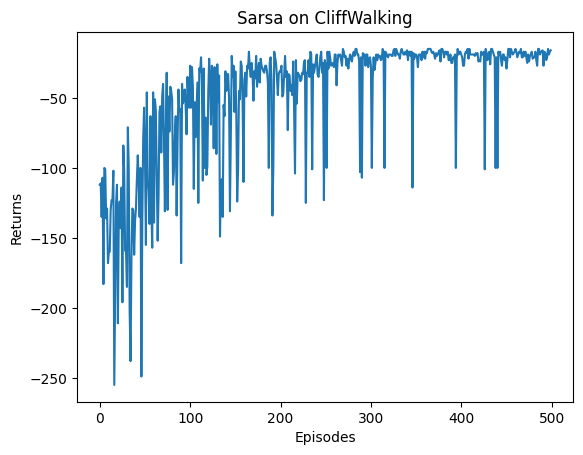

In [14]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(nrow, ncol)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol,nrow,epsilon,alpha,gamma)
num_episodes = 500


return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc = "Iteration %d"% i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False 
            while not done:
                next_state, reward,done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state,action,reward,next_state,next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return' : '%3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('CliffWalking'))
plt.show()

In [16]:
def print_agent(agent, env, action_meaning, disaster = [], end = []):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end =  '   ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end = '   ')
            else: 
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end = '   ')
        print()

action_meaning = ['^', 'v', '<', '>']
print('The optimal policy computed by Sarsa is: ')
print_agent(agent, env, action_meaning, list(range(37,47)), [47])


The optimal policy computed by Sarsa is: 
ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ovoo   
ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ovoo   
^ooo   ooo>   ^ooo   ooo>   ooo>   ooo>   ooo>   ^ooo   ^ooo   ooo>   ooo>   ovoo   
^ooo   ****   ****   ****   ****   ****   ****   ****   ****   ****   ****   EEEE   


**Monte Carlo Method** does not use estimation for value function at all, i.e it use observed total rewards to approximate value function where as **Temporal Difference Method** use the estimation for next state therefore it can be biased. In the same time, Monte Carlo Method often has large variance and Temporal Difference Method often has smaller variance. 

Multi-step Sarsa use reward for next n steps to approximate the value function, this method can effectively combined the advantage of both method. 

$$Q(s_t, a_t ) \leftarrow Q(s_t,a_t) + \alpha [r_t + \gamma r_{t+1} + \cdot + \gamma^n Q(s_{t+n}, a_{t+n}) - Q(s_t,a_t)]$$

In [21]:
class nstep_Sarsa:
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n
        self.state_list = []
        self.action_list = []
        self.reward_list = []


    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else: 
            action = np.argmax(self.Q_table[state])
        return action 
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a 
    
    def update(self, s0, a0,r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                if done and i >  0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s,a] += self.alpha * (G - self.Q_table[s,a])
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s,a] += self.alpha * (G - self.Q_table[s,a])
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 8567.50it/s, episode=500, return=-19.100]


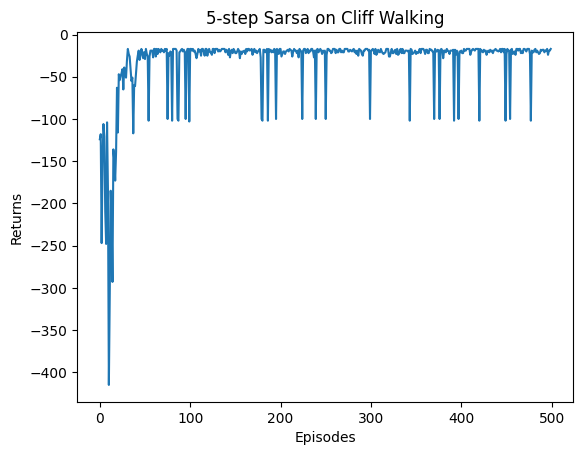

In [24]:
np.random.seed(0)
n_step = 5
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes/10), desc = "Iteration %d" % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False 
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state,action,reward,next_state,next_action,done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' %(num_episodes / 10 * i + i_episode + 1),
                    'return' : '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)


episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [25]:
print('The optimal policy compute by 5-step Sarsa is: ')
print_agent(agent,env,action_meaning,list(range(37,47)), [47])

The optimal policy compute by 5-step Sarsa is: 
ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ovoo   
^ooo   ^ooo   ^ooo   oo<o   ^ooo   ^ooo   ^ooo   ^ooo   ooo>   ooo>   ^ooo   ovoo   
ooo>   ^ooo   ^ooo   ^ooo   ^ooo   ^ooo   ^ooo   ooo>   ooo>   ^ooo   ooo>   ovoo   
^ooo   ****   ****   ****   ****   ****   ****   ****   ****   ****   ****   EEEE   


### Q-Learning 

Sarsa is an example of an on-policy algorithm, meaning it uses the next state-action pair—selected according to the current policy—to update the current state's value. In contrast, **Q-learning** is an off-policy algorithm. Instead of using the action chosen by the current policy in the next state, it uses the action with the maximum estimated value, regardless of the policy.

In Q-learning we update the state-action value by:

$$Q(s_t,a_t) \leftarrow Q(s_t, a_t) + \alpha [R_t + \gamma max_a Q(s_{t+1}, a) - Q(s_t,a_t)]

In [26]:
class QLearning:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma,n_action = 4) -> None:
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self,s0,a0,r,s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0,a0]
        self.Q_table[s0,a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4305.91it/s, episode=500, return=-34.200]


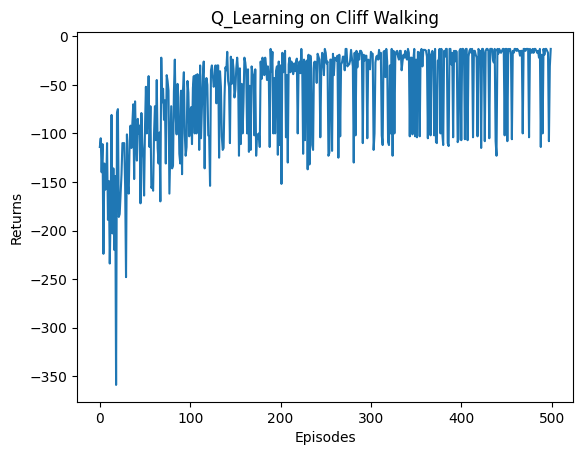

In [27]:
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow,epsilon,alpha,gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes/10), desc= 'Iteration %d' %i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False 
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward
                agent.update(state,action,reward,next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 ==0:
                pbar.set_postfix({
                    'episode': '%d' %(num_episodes /10 * i + i_episode + 1),
                    'return' : '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q_Learning on {}'.format('Cliff Walking'))
plt.show()

In [28]:
print_agent(agent,env,action_meaning,list(range(37,47)), [47])

oo<o   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ovoo   ovoo   
ovoo   ovoo   ovoo   ooo>   ooo>   ooo>   ooo>   ovoo   ooo>   ovoo   ooo>   ovoo   
ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ooo>   ovoo   
^ooo   ****   ****   ****   ****   ****   ****   ****   ****   ****   ****   EEEE   
